In [652]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split


In [753]:
TICKER = 'NVDA'

In [754]:
# Load the CSV file
data = pd.read_csv('../data/year_delta.csv')

# Change all empty of inf values to 0.0
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0.0)

 # Filter by symbol
data = data[data['act_symbol'] == TICKER]

# Get the most recent date to use with the chart
last_date_for_chart = data['date'].iloc[-1]

# Separate features (X) and target (y)
features = data.drop(columns=['adjusted_price', 'date', 'act_symbol'])
target = data['adjusted_price']

# Drop problematic columns entirely for consistency
features = features.dropna(axis=1)

# Retain the last row before excluding it for training
last_row = features.iloc[-1:]

# Exclude the last row for training
features = features[:-1]

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_X.fit_transform(features)
scaled_target = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Preprocess the last row
scaled_last_row = scaler_X.transform(last_row)


In [755]:
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=False)

In [756]:
# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [757]:
# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Print the loss
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Print the r2 score
y_pred = model.predict(X_test)
r2 = np.corrcoef(y_test.flatten(), y_pred.flatten())[0, 1] ** 2
print(f'R2: {r2}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1393
Loss: 0.1392986923456192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
R2: 1.0


In [758]:
# Prepare the last sequence for prediction
# Use the last `time_steps` rows from the scaled_features plus the scaled_last_row
last_sequence = np.vstack([scaled_features[-(time_steps - 1):], scaled_last_row])
last_sequence = last_sequence.reshape(1, time_steps, -1)  # Reshape for LSTM input

# Make the prediction
predicted_scaled_price = model.predict(last_sequence)

# Inverse transform the scaled prediction to get the actual price
predicted_price = scaler_y.inverse_transform(predicted_scaled_price)
print("Predicted price for the last row:", predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted price for the last row: 1.8547511


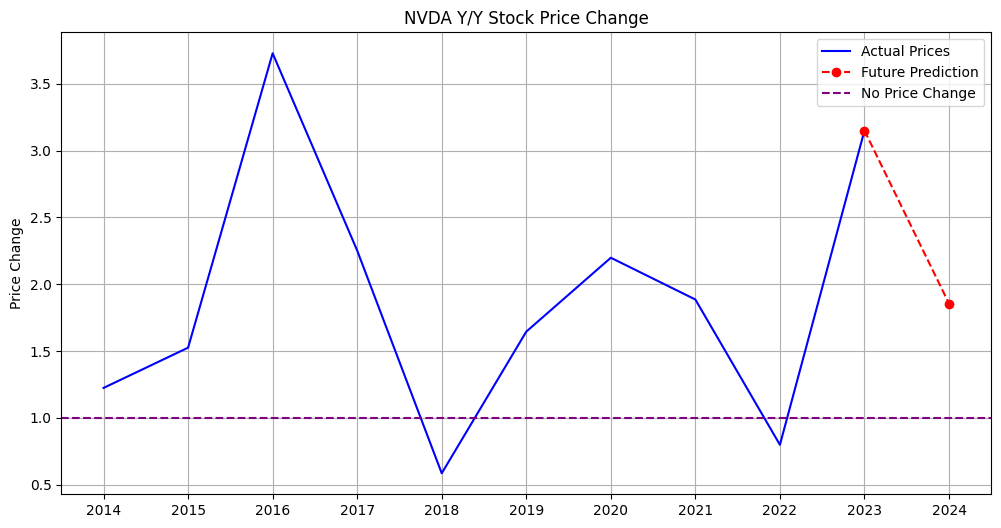

Predicted Price Change for the Next Year: 1.85


In [759]:
import matplotlib.pyplot as plt

# Prepare historical data
historical_prices = scaler_y.inverse_transform(scaled_target).flatten()

# Generate years for the x-axis, starting from the next year
# Companies report yearly earning in either September or October of that year, or Janurary of the next year
# In the case that it is Janurary, make a prediction on that year, otherwise, the model is techincally making
# A prediction on the following year
last_year = int(last_date_for_chart.split('-')[0])
last_year = last_year if int(last_date_for_chart.split('-')[1]) == 1 else last_year + 1
timeline_years = [last_year - i for i in range(len(historical_prices))]
timeline_years = timeline_years[::-1]

# Extend timeline and prices for future prediction
extended_timeline = timeline_years + [timeline_years[-1] + 1]
extended_prices = list(historical_prices) + [predicted_price[0][0]]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(timeline_years[0: -1], historical_prices[0: -1], label="Actual Prices", color="blue", linestyle="-")

plt.plot([timeline_years[-2], extended_timeline[-2]], [historical_prices[-2], predicted_price[0][0]], 
         label="Future Prediction", color="red", linestyle="--", marker='o')

# Add a horizontal line at y = 1
plt.axhline(y=1, color='purple', linestyle='--', label="No Price Change")

plt.title(f"{TICKER} Y/Y Stock Price Change")
plt.xlabel("")
plt.xticks(timeline_years)
plt.ylabel("Price Change")
plt.legend(loc="best")
plt.grid()
plt.show()

print(f"Predicted Price Change for the Next Year: {predicted_price[0][0]:.2f}")